# Siemens Energy Coding Challenge - Task 2 - 2021 - Sam MacIntyre

This jupyter notebook contains the code related to task 1, the jupyter notebook follows the structure below:

- Task outline
- Environment and version control
- Problem approach
- Data and library loading
- Data exploration and summary statistics
- Temporal alignment
- NAN treatment
- Moving average predictions
- Reproduce plots
- Conclusions and discussion

## Task outline

Condition monitoring is crucial to prevent equipment failures, optimize maintenance timing and assess intervention benefits.
In this task you will have to forecast the remaining useful life of the components given their current status at the end of the timeseries.

The data set consists of multiple multivariate time series.
Each time series is from a different engine, but the data can be considered to be from a fleet of engines of the same type.
Each engine starts with different degrees of initial wear and manufacturing variation which is unknown but still considered normal, i.e. not a fault condition.
Each engine operates at similar ambient conditions and evolves towards only one kind of failure.
There are three operational settings that have a substantial effect on engine performance.
These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series.
In the training set, the fault grows in magnitude until system failure.
In the test set, the time series ends some time prior to system failure.
The objective is to predict the number of remaining operational cycles before failure in the test set, i.e. the number of operational cycles after the last cycle that the engine will continue to operate.

The data are provided as a text file with 26 columns of numbers, separated by spaces.
Each row is a snapshot of data taken during a single operational cycle, each column is a different variable.
The columns correspond to:

1)	unit number

2)	time, in cycles

3)	operational setting 1

4)	operational setting 2

5)	operational setting 3

6)	sensor measurement  1

7)	sensor measurement  2
...
26)	sensor measurement  21

You should build a machine learning algorithm able to predict the remaining useful cycles and then try to answer some questions:
1. How would you change your approach if instead of similar ambient conditions we would have six different climates?
2. What if we had an additional possible kind of failure? How would you approach the problem then?

## Environment and version control

A temporary Github repository will be used to employ version control and protect against loss of code. Furthermore, a standard Python3 venv has been set up to ensure a clean and reproducible coding environment.

## Problem approach

- Aim is to **predict** the number of operational cycles (after the last cycle) that the engine will operate until failure
- Assume system failure has been achieved at end of time series in test set

## Data and library loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Load training dataset
df_train = pd.read_csv('data/Task 2/train_FD001.txt', sep = " ", header = None)

In [10]:
# Load testing dataset
df_test = pd.read_csv('data/Task 2/test_FD001.txt', sep = " ", header = None)

In [23]:
# Explore data
df_test

,unit,time (cycles),O1,O2,O3,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN


In [17]:
# rename columns
df_train.rename(columns = {0:"unit", 1: "time (cycles)", 2:"O1", 3:"O2", 4:"O3"}, inplace = True)
df_test.rename(columns = {0:"unit", 1: "time (cycles)", 2:"O1", 3:"O2", 4:"O3"}, inplace = True)

In [18]:
df_train.columns

Index([         'unit', 'time (cycles)',            'O1',            'O2',
                  'O3',               5,               6,               7,
                     8,               9,              10,              11,
                    12,              13,              14,              15,
                    16,              17,              18,              19,
                    20,              21,              22,              23,
                    24,              25,              26,              27],
      dtype='object')

In [20]:
df_test

,unit,time (cycles),O1,O2,O3,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,NaN,NaN
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,NaN,NaN
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,NaN,NaN
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,NaN,NaN


<AxesSubplot:>

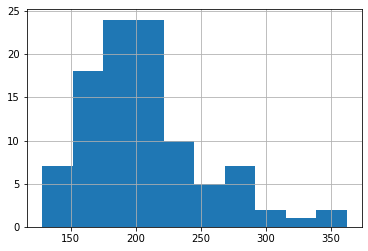

In [30]:
# plot distribution of failure times
df_train.groupby('unit').max()['time (cycles)'].hist()

### Create the target variable

To create the target variable, must subtract current cycle from failure cycle

In [32]:
# Create dataframe containing failure cycle for each unit
df_maxes = df_train.groupby('unit').max()['time (cycles)']

In [34]:
# Merge maxes to main_df
df_train = df_train.merge(df_maxes, on = 'unit')

In [35]:
df_train

,unit,time (cycles)_x,O1,O2,O3,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,time (cycles)_y
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8.4956,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,200
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8.5139,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,200
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8.5646,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,200
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8.5389,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,200


In [36]:
# Calculate target variable
df_train['Cycles to failure'] = df_train['time (cycles)_y'] - df_train['time (cycles)_x']

In [37]:
df_train

,unit,time (cycles)_x,O1,O2,O3,5,6,7,8,9,...,20,21,22,23,24,25,26,27,time (cycles)_y,Cycles to failure
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN,192,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN,192,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN,192,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN,192,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN,192,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,0.03,397,2388,100.0,38.49,22.9735,NaN,NaN,200,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,0.03,395,2388,100.0,38.30,23.1594,NaN,NaN,200,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,0.03,398,2388,100.0,38.44,22.9333,NaN,NaN,200,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,0.03,395,2388,100.0,38.29,23.0640,NaN,NaN,200,1
